 **Machine Learning Project**

**Lorenzo Russo 2091186**

In [ ]:
!apt-get install -y xvfb python-opengl
!pip install gym pyvirtualdisplay
!apt-get install x11-utils
!pip install pyglet

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
!pip install --upgrade pip setuptools
!apt-get install -y swig
!apt-get install -y freeglut3-dev
!pip install gym[box2d]
!apt-get install -y xvfb python-opengl ffmpeg

In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import random
import matplotlib
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
import sys
from collections import deque,namedtuple
import os
import time
from keras import models
from keras import layers
from tensorflow.keras.optimizers import Adam
import imageio

**Agent class, with all the function to training**

In [ ]:
class AgentMountainCar:
    def __init__(self,env):
        self.env=env
        self.gamma=None

        self.epsilon = 1 # starting by max exploration probability
        self.epsilon_decay = None
        self.epsilon_min=0.01

        self.learningRate=0.001
        self.experience=deque(maxlen=10000)

        self.episodeNum=None
        self.iterationNum=200
        self.BufferSize=None

        self.rewards = []
        self.maxpos = []

    def init_hyperparameters(self, n_episodes, batch_size, gamma, lr, decay):
        self.episodeNum = n_episodes
        self.BufferSize = batch_size
        self.gamma = gamma
        self.learningRate = lr
        self.epsilon_decay = decay
        self.trainNetwork=self.createNetwork()
        self.targetNetwork=self.createNetwork()
        self.targetNetwork.set_weights(self.trainNetwork.get_weights())

    def createNetwork(self):

        model = models.Sequential()
        state_shape = self.env.observation_space.shape

        model.add(layers.Dense(24, activation='relu', input_shape=state_shape))
        model.add(layers.Dense(48, activation='relu'))
        model.add(layers.Dense(self.env.action_space.n,activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learningRate))
        return model

    def getBestAction(self,state): # EpsGreedyPolicy

        self.epsilon = max(self.epsilon_min, self.epsilon) # value epsilon to decide between exploitation or exploration

        if np.random.rand(1) < self.epsilon:
            action = np.random.randint(0, 3) # exploration
        else:
            action=np.argmax(self.trainNetwork.predict(state, verbose=0)[0]) # exploitation (select the action that maximize the Q)

        return action

    def trainFromBuffer(self):

        samples = random.sample(self.experience,self.BufferSize)
        states = []
        newStates=[]

        for sample in samples:
            state, action, reward, new_state, done = sample
            states.append(state)
            newStates.append(new_state)

        newArray = np.array(states)
        states = newArray.reshape(self.BufferSize, 2)

        newArray2 = np.array(newStates)
        newStates = newArray2.reshape(self.BufferSize, 2)

        targets = self.trainNetwork.predict(states, verbose=0)
        new_state_targets=self.targetNetwork.predict(newStates, verbose=0)

        i=0
        for sample in samples:
            state, action, reward, new_state, done = sample
            if done:
                targets[i][action] = reward
            else:
                Q_future = max(new_state_targets[i])  # Q_future = max(Q(s', a'))
                targets[i][action] = reward + Q_future * self.gamma  #  Q(s, a) = r + Q_future * gamma
            i+=1

        self.trainNetwork.fit(states, targets, epochs=1, verbose=0)


    def trainEpisode(self,currentState,eps):

        if eps % 10 == 0:
            render = True
        else:
            render = False

        rewardSum = 0
        max_position = -99
        frames = []

        for i in range(self.iterationNum):
            bestAction = self.getBestAction(currentState)

            if eps%10==0:
                self.env.render()

            new_state, reward, done, _ = self.env.step(bestAction)

            new_state = new_state.reshape(1, 2)

            if render:
                 frames.append(self.env.render(mode="rgb_array"))

            if new_state[0][0] > max_position:
                max_position = new_state[0][0]

            self.experience.append([currentState, bestAction, reward, new_state, done])

            if len(self.experience) >= self.BufferSize:
                self.trainFromBuffer()

            rewardSum += reward

            currentState = new_state

            if done:
                break

        if render:
             print(frames[0].shape)
             imageio.mimsave(f'./{eps}.gif', frames, fps=40)

        if i < 199:
            print("Success!!!! in episode {}. Current reward: {}. Current Max Position: {}!".format(eps, rewardSum, max_position))
            self.trainNetwork.save('./trainNetworkInEPS{}.h5'.format(eps))
        elif (i==199) and (eps > 0):
            print("Failure in episode {}. Current reward: {}. Current Max Position: {}!".format(eps, rewardSum, max_position))


        # Sync
        # Update target_network weights each 5 episodes
        if (eps + 1) % 5 == 0:
            self.targetNetwork.set_weights(self.trainNetwork.get_weights())

        self.epsilon *= self.epsilon_decay # reduce the epsilon, reduce the exploration probability and increse the exploitation probability
        self.rewards.append(rewardSum)
        self.maxpos.append(max_position)

    def train(self):
        for eps in range(self.episodeNum):
            currentState=self.env.reset().reshape(1,2)
            self.trainEpisode(currentState, eps)


In [ ]:
env = gym.make('MountainCar-v0')
env.reset()

array([-0.4115025,  0.       ], dtype=float32)

In [ ]:
def plot_agent_rewards(agent):
    fig, ax = plt.subplots(1,figsize=(10,8))
    ax.plot(agent.rewards)
    ax.set_title("Agent Reward Progression across Episodes", fontsize = 16)
    ax.set_ylabel('Reward', fontsize = 14)
    ax.set_xlabel('Episodes', fontsize = 14)
    plt.grid()
    plt.show()

In [ ]:
def plot_agent_maxpos(agent):
    fig, ax = plt.subplots(1,figsize=(10,8))
    ax.plot(agent.maxpos)
    ax.set_title("Agent Max position Progression across Episodes", fontsize = 16)
    ax.set_ylabel('Max Position', fontsize = 14)
    ax.set_xlabel('Episodes', fontsize = 14)
    plt.grid()
    plt.show()

**Training phase**

In [ ]:
agent=AgentMountainCar(env=env)

n_episodes=300
batch_size=128
gamma = 0.99 # discount factor
lr = 0.001 # learning rate
decay = 0.95 # decay (decadimento) rate for epsilon (exploitation or exploration)

agent.init_hyperparameters(n_episodes, batch_size, gamma, lr, decay)
agent.train()

(400, 600, 3)
Failure in episode 1. Current reward: -200.0. Current Max Position: -0.45392319560050964!
Failure in episode 2. Current reward: -200.0. Current Max Position: -0.3407953679561615!
Failure in episode 3. Current reward: -200.0. Current Max Position: -0.3894706070423126!
Failure in episode 4. Current reward: -200.0. Current Max Position: -0.4200291037559509!
Failure in episode 5. Current reward: -200.0. Current Max Position: -0.3095168173313141!
Failure in episode 6. Current reward: -200.0. Current Max Position: -0.30821260809898376!
Failure in episode 7. Current reward: -200.0. Current Max Position: -0.34924665093421936!
Failure in episode 8. Current reward: -200.0. Current Max Position: -0.34693557024002075!
Failure in episode 9. Current reward: -200.0. Current Max Position: -0.3422173857688904!
(400, 600, 3)
Failure in episode 10. Current reward: -200.0. Current Max Position: -0.40481534600257874!
Failure in episode 11. Current reward: -200.0. Current Max Position: -0.3911

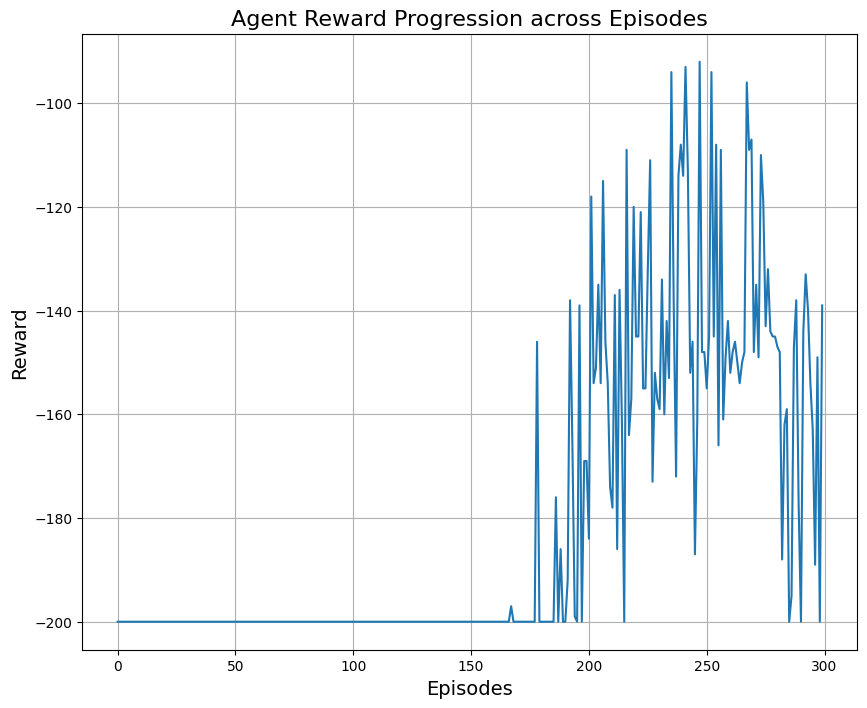

In [ ]:
plot_agent_rewards(agent)

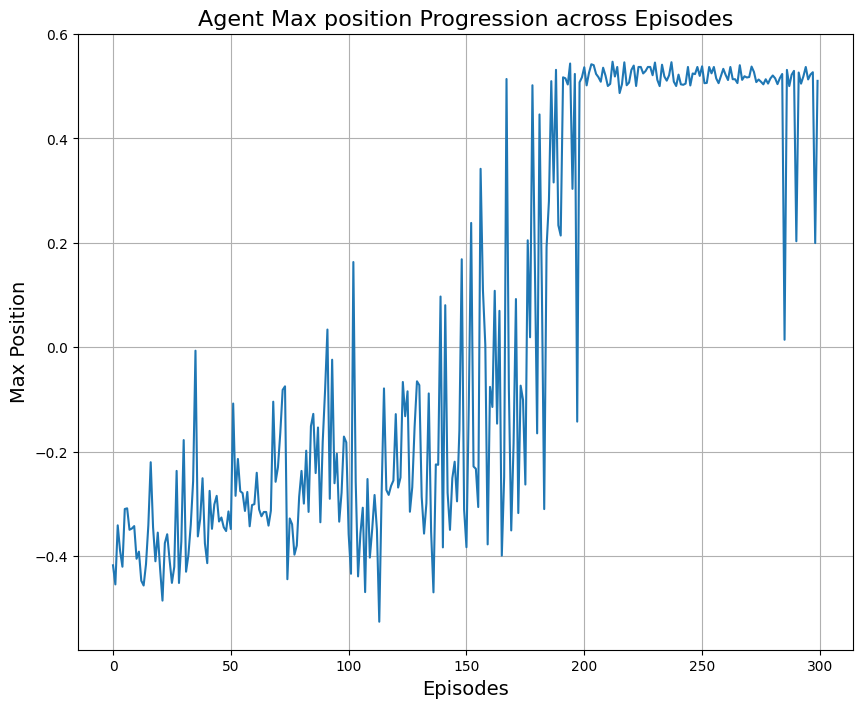

In [ ]:
plot_agent_maxpos(agent)

**Agent with train Network**

In [ ]:
# Load the pre-trained model
model = tf.keras.models.load_model('/content/trainNetworkInEPS299.h5')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                72        
                                                                 
 dense_7 (Dense)             (None, 48)                1200      
                                                                 
 dense_8 (Dense)             (None, 3)                 147       
                                                                 
Total params: 1,419
Trainable params: 1,419
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_episodes = 100
tot_reward = 0
episode = 0
goal_count = 0
rewards = []

for episode in range(num_episodes):
    state = env.reset()
    done = False
    tot_reward = 0

    frames = []
    while not done:
        state = np.reshape(state, (1, 2))
        action = np.argmax(model.predict(state, verbose=0)[0])

        next_state, reward, done, _= env.step(action)
        state = next_state
        env.render(mode="rgb_array")
        #frames.append(env.render(mode="rgb_array"))
        tot_reward = tot_reward + reward

    if tot_reward > -200:
        goal_count = goal_count + 1

    rewards.append(tot_reward)

    print(f"Episode {episode + 1}: Total Reward = {tot_reward}")

    #imageio.mimsave(f'./{episode + 1}.gif', frames, fps=40)
print('\n')
print("Number of times the car has reached the goal: ", goal_count)
print("\nnumber of times the car did not reach the goal: ", num_episodes - goal_count)
env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 1: Total Reward = -127.0
Episode 2: Total Reward = -129.0
Episode 3: Total Reward = -127.0
Episode 4: Total Reward = -144.0
Episode 5: Total Reward = -142.0
Episode 6: Total Reward = -137.0
Episode 7: Total Reward = -136.0
Episode 8: Total Reward = -140.0
Episode 9: Total Reward = -142.0
Episode 10: Total Reward = -144.0
Episode 11: Total Reward = -135.0
Episode 12: Total Reward = -138.0
Episode 13: Total Reward = -142.0
Episode 14: Total Reward = -138.0
Episode 15: Total Reward = -138.0
Episode 16: Total Reward = -144.0
Episode 17: Total Reward = -144.0
Episode 18: Total Reward = -129.0
Episode 19: Total Reward = -145.0
Episode 20: Total Reward = -137.0
Episode 21: Total Reward = -127.0
Episode 22: Total Reward = -132.0
Episode 23: Total Reward = -134.0
Episode 24: Total Reward = -127.0
Episode 25: Total Reward = -143.0
Episode 26: Total Reward = -138.0
Episode 27: Total Reward = -127.0
Episode 28: Total Reward = -130.0
Episode 29: Total Reward = -129.0
Episode 30: Total Rewar

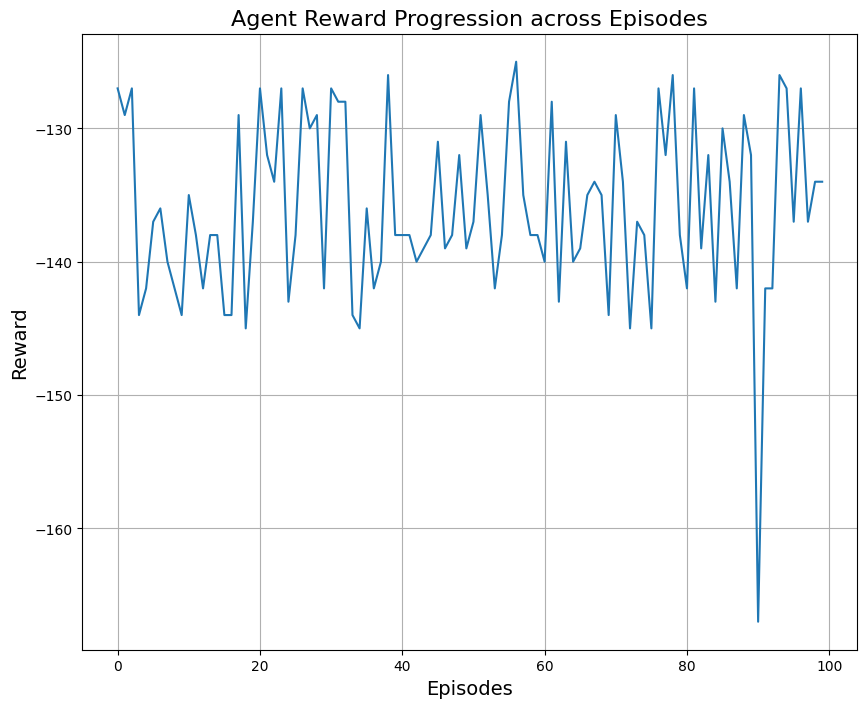

In [ ]:
  fig, ax = plt.subplots(1,figsize=(10,8))
  ax.plot(rewards)
  ax.set_title("Agent Reward Progression across Episodes", fontsize = 16)
  ax.set_ylabel('Reward', fontsize = 14)
  ax.set_xlabel('Episodes', fontsize = 14)
  plt.grid()
  plt.show()

 **Random agent**

In [ ]:
num_episodes = 100
tot_reward = 0
episode = 0
goal_count = 0

for episode in range(num_episodes):
    state = env.reset()
    done = False
    tot_reward = 0

    frames = []
    while not done:
        state = np.reshape(state, (1, 2))
        action = np.random.randint(0, 3)

        next_state, reward, done, _= env.step(action)
        state = next_state
        env.render(mode="rgb_array")
        #frames.append(env.render(mode="rgb_array"))
        tot_reward = tot_reward + reward

    if tot_reward > -200:
        goal_count = goal_count + 1

    print(f"Episode {episode + 1}: Total Reward = {tot_reward}")

    #imageio.mimsave(f'./{episode + 1}.gif', frames, fps=40)
print('\n')
print("Number of times the car has reached the goal: ", goal_count)
print("\nnumber of times the car did not reach the goal: ", num_episodes - goal_count)
env.close()

Episode 1: Total Reward = -200.0
Episode 2: Total Reward = -200.0
Episode 3: Total Reward = -200.0
Episode 4: Total Reward = -200.0
Episode 5: Total Reward = -200.0
Episode 6: Total Reward = -200.0
Episode 7: Total Reward = -200.0
Episode 8: Total Reward = -200.0
Episode 9: Total Reward = -200.0
Episode 10: Total Reward = -200.0
Episode 11: Total Reward = -200.0
Episode 12: Total Reward = -200.0
Episode 13: Total Reward = -200.0
Episode 14: Total Reward = -200.0
Episode 15: Total Reward = -200.0
Episode 16: Total Reward = -200.0
Episode 17: Total Reward = -200.0
Episode 18: Total Reward = -200.0
Episode 19: Total Reward = -200.0
Episode 20: Total Reward = -200.0
Episode 21: Total Reward = -200.0
Episode 22: Total Reward = -200.0
Episode 23: Total Reward = -200.0
Episode 24: Total Reward = -200.0
Episode 25: Total Reward = -200.0
Episode 26: Total Reward = -200.0
Episode 27: Total Reward = -200.0
Episode 28: Total Reward = -200.0
Episode 29: Total Reward = -200.0
Episode 30: Total Rewar

**Performance analysis of train model with a variant of Mountain Car**

**Variant of Mountain Car**

In [ ]:
import math
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled


class MountainCarEnv(gym.Env):

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }

    def __init__(self, render_mode: Optional[str] = None, goal_velocity=0):
        self.min_position = -1.2
        self.max_position = 0.6
        self.max_speed = 0.07
        self.goal_position = 0.5
        self.goal_velocity = goal_velocity

        self.force = 0.001
        self.gravity = 0.0025

        self.low = np.array([self.min_position, -self.max_speed], dtype=np.float32)
        self.high = np.array([self.max_position, self.max_speed], dtype=np.float32)

        self.render_mode = render_mode

        self.screen_width = 600
        self.screen_height = 400
        self.screen = None
        self.clock = None
        self.isopen = True

        self.yBox = 0.2
        self.xBox = -0.3
        self.box = 0
        self.boxVisible = False

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(self.low, self.high, dtype=np.float32)

    def check_collision(self, position):
        block_width = 0.06  # Width of the block

        # check if the machine goes through the laser
        if (
            ((position >= self.xBox and position <= self.xBox + block_width) or (position <= self.xBox + block_width and position >= self.xBox))
        ):
            return True  # Collision occurred
        else:
            return False  # No collision

    def step(self, action: int):
        assert self.action_space.contains(
            action
        ), f"{action!r} ({type(action)}) invalid"

        position, velocity = self.state
        velocity += (action - 1) * self.force + math.cos(3 * position) * (-self.gravity)
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)
        position += velocity
        position = np.clip(position, self.min_position, self.max_position)
        if position == self.min_position and velocity < 0:
            velocity = 0

        # check if the machine goes through the laser
        if self.check_collision(position) and self.boxVisible == True:
            velocity = 0

        terminated = bool(
            position >= self.goal_position and velocity >= self.goal_velocity
        )
        reward = -1.0
        self.state = (position, velocity)
        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32), reward, terminated, {}

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        # Note that if you use custom reset bounds, it may lead to out-of-bound
        # state/observations.
        low, high = utils.maybe_parse_reset_bounds(options, -0.6, -0.4)
        self.state = np.array([self.np_random.uniform(low=low, high=high), 0])

        self.box = 0
        self.boxVisible = False


        if self.render_mode == "human":
            self.render()
        return np.array(self.state, dtype=np.float32)

    def _height(self, xs):
        return np.sin(3 * xs) * 0.45 + 0.55

    def render(self):
        if self.render_mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if self.render_mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_width, self.screen_height)
                )
            else:  # mode in "rgb_array"
                self.screen = pygame.Surface((self.screen_width, self.screen_height))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        world_width = self.max_position - self.min_position
        scale = self.screen_width / world_width
        carwidth = 40
        carheight = 20

        self.surf = pygame.Surface((self.screen_width, self.screen_height))
        self.surf.fill((255, 255, 255))

        pos = self.state[0]

        xs = np.linspace(self.min_position, self.max_position, 100)
        ys = self._height(xs)
        xys = list(zip((xs - self.min_position) * scale, ys * scale))

        pygame.draw.aalines(self.surf, points=xys, closed=False, color=(0, 0, 0))

        clearance = 10

        l, r, t, b = -carwidth / 2, carwidth / 2, carheight, 0
        coords = []
        for c in [(l, b), (l, t), (r, t), (r, b)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            coords.append(
                (
                    c[0] + (pos - self.min_position) * scale,
                    c[1] + clearance + self._height(pos) * scale,
                )
            )

        gfxdraw.aapolygon(self.surf, coords, (0, 0, 0))
        gfxdraw.filled_polygon(self.surf, coords, (0, 0, 0))

        for c in [(carwidth / 4, 0), (-carwidth / 4, 0)]:
            c = pygame.math.Vector2(c).rotate_rad(math.cos(3 * pos))
            wheel = (
                int(c[0] + (pos - self.min_position) * scale),
                int(c[1] + clearance + self._height(pos) * scale),
            )

            gfxdraw.aacircle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )
            gfxdraw.filled_circle(
                self.surf, wheel[0], wheel[1], int(carheight / 2.5), (128, 128, 128)
            )

        flagx = int((self.goal_position - self.min_position) * scale)
        flagy1 = int(self._height(self.goal_position) * scale)
        flagy2 = flagy1 + 40
        gfxdraw.vline(self.surf, flagx, flagy1, flagy2, (0, 0, 0))

        gfxdraw.aapolygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )
        gfxdraw.filled_polygon(
            self.surf,
            [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)],
            (204, 204, 0),
        )


        # Define laser
        square_size = 20
        square_x = int((self.xBox - self.min_position) * scale)
        square_y = int(self.yBox * scale)

        e = pygame.Rect(square_x, square_y, square_size, square_size + 350)
        # Draw the red laser on the screen
        if self.box >= 50:
            self.boxVisible = True
            gfxdraw.box(self.surf, e, (255, 0, 0))
            self.box = self.box + 1
            if self.box == 100:
                self.box = 0
                self.boxVisible = False
        elif self.box < 50:
            self.box = self.box + 1


        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if self.render_mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        elif self.render_mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

    def get_keys_to_action(self):
        # Control with left and right arrow keys.
        return {(): 1, (276,): 0, (275,): 2, (275, 276): 1}

    def close(self):
        if self.screen is not None:
            import pygame

            pygame.display.quit()
            pygame.quit()
            self.isopen = False

In [ ]:
envNew = MountainCarEnv(render_mode="rgb_array")
envNew.reset()

In [ ]:
# Load the pre-trained model
model = tf.keras.models.load_model('/content/trainNetworkInEPS299.h5')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 24)                72        
                                                                 
 dense_7 (Dense)             (None, 48)                1200      
                                                                 
 dense_8 (Dense)             (None, 3)                 147       
                                                                 
Total params: 1,419
Trainable params: 1,419
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_episodes = 100
tot_reward = 0
episode = 0
goal_count = 0
rewards = []
c = 200

for episode in range(num_episodes):
    state = envNew.reset()
    done = False
    tot_reward = 0

    frames = []
    #while not done:
    for i in range(c):
        state = np.reshape(state, (1, 2))
        action = np.argmax(model.predict(state, verbose=0)[0])

        next_state, reward, done, _= envNew.step(action)
        state = next_state
        #envNew.render()
        frames.append(envNew.render())
        tot_reward = tot_reward + reward
        if done:
            break

    if tot_reward > -200:
        goal_count = goal_count + 1
        imageio.mimsave(f'./TEST_Classic{episode + 1}.gif', frames, fps=40)

    rewards.append(tot_reward)
    #if episode % 5 == 0 and tot_reward == -200:
     #   imageio.mimsave(f'./{episode + 1}.gif', frames, fps=40)

    print(f"Episode {episode + 1}: Total Reward = {tot_reward}")
    #imageio.mimsave(f'./{episode + 1}.gif', frames, fps=40)
    #if episode % 10 == 0:
     #   imageio.mimsave(f'./{episode + 1}.gif', frames, fps=40)
print('\n')
print("Number of times the car has reached the goal: ", goal_count)
print("\nnumber of times the car did not reach the goal: ", num_episodes - goal_count)
env.close()

Episode 1: Total Reward = -162.0
Episode 2: Total Reward = -136.0
Episode 3: Total Reward = -200.0
Episode 4: Total Reward = -138.0
Episode 5: Total Reward = -169.0
Episode 6: Total Reward = -159.0
Episode 7: Total Reward = -146.0
Episode 8: Total Reward = -165.0
Episode 9: Total Reward = -135.0
Episode 10: Total Reward = -162.0
Episode 11: Total Reward = -136.0
Episode 12: Total Reward = -150.0
Episode 13: Total Reward = -147.0
Episode 14: Total Reward = -134.0
Episode 15: Total Reward = -160.0
Episode 16: Total Reward = -160.0
Episode 17: Total Reward = -147.0
Episode 18: Total Reward = -136.0
Episode 19: Total Reward = -149.0
Episode 20: Total Reward = -148.0
Episode 21: Total Reward = -147.0
Episode 22: Total Reward = -135.0
Episode 23: Total Reward = -140.0
Episode 24: Total Reward = -159.0
Episode 25: Total Reward = -148.0
Episode 26: Total Reward = -155.0
Episode 27: Total Reward = -141.0
Episode 28: Total Reward = -144.0
Episode 29: Total Reward = -165.0
Episode 30: Total Rewar

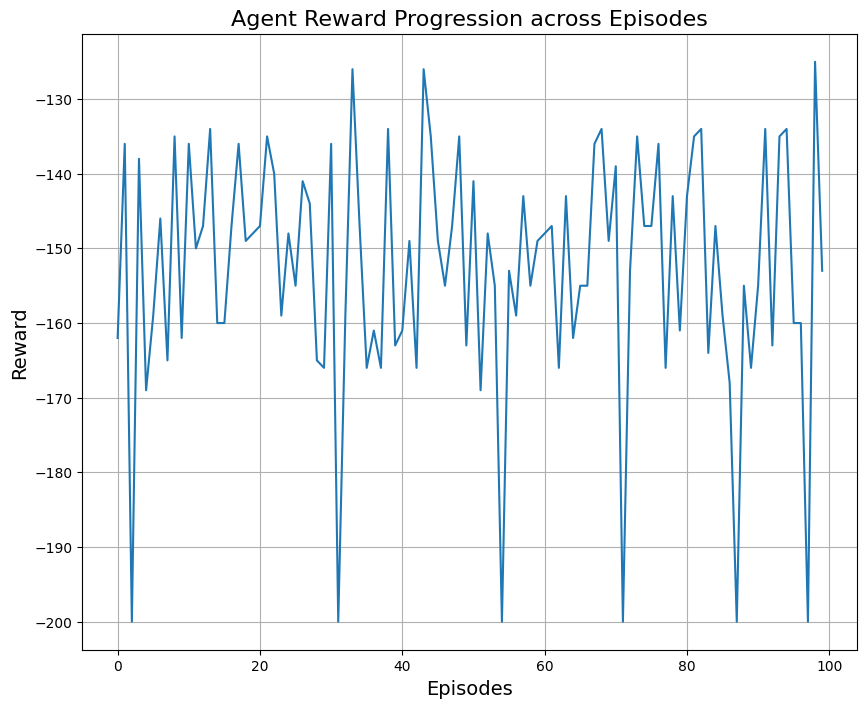

In [ ]:
fig, ax = plt.subplots(1,figsize=(10,8))
ax.plot(rewards)
ax.set_title("Agent Reward Progression across Episodes", fontsize = 16)
ax.set_ylabel('Reward', fontsize = 14)
ax.set_xlabel('Episodes', fontsize = 14)
plt.grid()
plt.show()